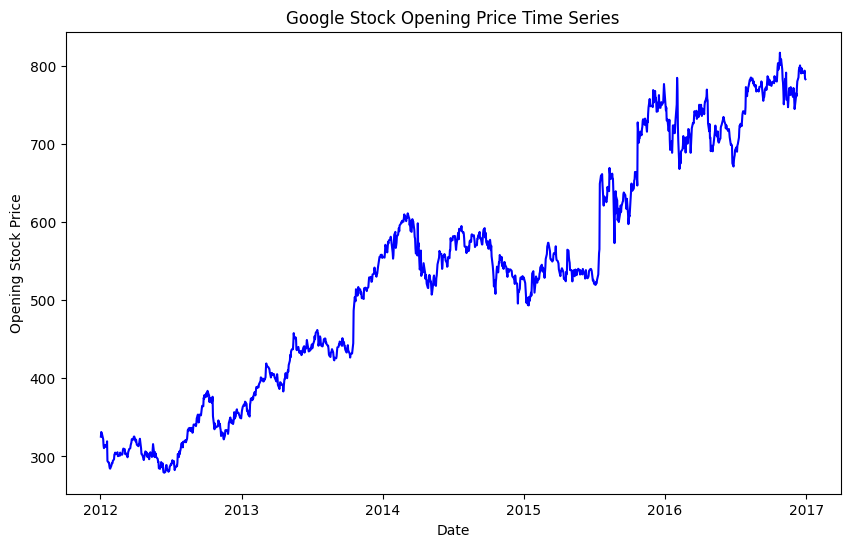

ADF Statistic: -0.7762114964086172
p-value: 0.8260100940100733
Critical Values:
	1%: -3.4355629707955395
	5%: -2.863842063387667
	10%: -2.567995644141416


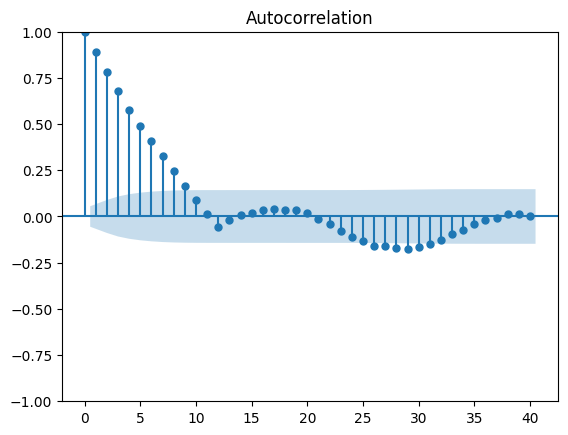

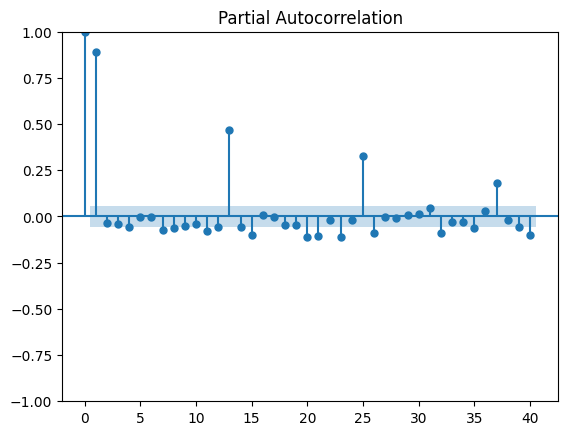

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=2.92 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=9660.931, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=9307.599, Time=0.34 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=1.55 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=9662.281, Time=0.06 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=9121.681, Time=0.74 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=9069.511, Time=1.50 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=inf, Time=24.52 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=6.58 sec
 ARIMA(0,1,0)(3,1,0)[12]             : AIC=9068.437, Time=1.63 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=9119.894, Time=0.71 sec
 ARIMA(0,1,0)(3,1,1)[12]             : AIC=inf, Time=16.10 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=5.14 sec
 ARIMA(0,1,1)(3,1,0)[12]             : AIC=9069.587, Time=1.64 sec
 ARIMA(1,1,1)(3,1,0)[12]             : AIC=inf,

C:\Users\SEC\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\SEC\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\SEC\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\SEC\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without

RMSE: 67.85625202911254


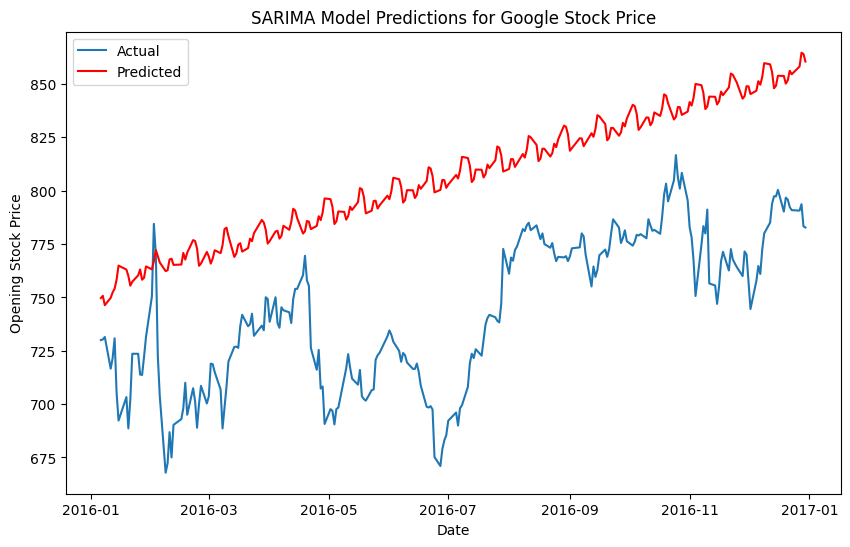

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import pmdarima as pm

# Load the Google stock price dataset
data = pd.read_csv('Google_Stock_Price_Train.csv')
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Plot the time series
plt.figure(figsize=(10, 6))
plt.plot(data['Open'], color='blue')
plt.xlabel('Date')
plt.ylabel('Opening Stock Price')
plt.title('Google Stock Opening Price Time Series')
plt.show()

# Check stationarity of 'Open' prices
def check_stationarity(timeseries):
    result = adfuller(timeseries)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value}')

check_stationarity(data['Open'])

# Seasonal Differencing for Potentially Better Stationarity
data['Open_diff'] = data['Open'] - data['Open'].shift(12)
data.dropna(inplace=True)

# Plotting ACF and PACF
plot_acf(data['Open_diff'], lags=40)
plt.show()

plot_pacf(data['Open_diff'], lags=40)
plt.show()

# Step 1: Auto ARIMA for Best Parameters
auto_arima_model = pm.auto_arima(
    data['Open'],
    start_p=1, start_q=1, max_p=3, max_q=3,
    seasonal=True, m=12, start_P=1, start_Q=1, max_P=3, max_Q=3,
    d=1, D=1,
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)
print(auto_arima_model.summary())

# Step 2: Split data into train and test sets
train_size = int(len(data) * 0.8)
train, test = data['Open'][:train_size], data['Open'][train_size:]

# Use the parameters suggested by Auto ARIMA
order = auto_arima_model.order
seasonal_order = auto_arima_model.seasonal_order

# Step 3: Fit the SARIMA model with the chosen parameters
sarima_model = SARIMAX(train, order=order, seasonal_order=seasonal_order)
sarima_result = sarima_model.fit(disp=False)

# Step 4: Forecasting
predictions = sarima_result.predict(start=len(train), end=len(data)-1, dynamic=False)

# Step 5: Evaluate the model with RMSE
mse = mean_squared_error(test, predictions)
rmse = np.sqrt(mse)
print('RMSE:', rmse)

# Step 6: Plot Actual vs. Predicted
plt.figure(figsize=(10, 6))
plt.plot(test.index, test, label='Actual')
plt.plot(test.index, predictions, color='red', label='Predicted')
plt.xlabel('Date')
plt.ylabel('Opening Stock Price')
plt.title('SARIMA Model Predictions for Google Stock Price')
plt.legend()
plt.show()
